In [1]:
import sys
print(sys.version)

3.6.2 (default, Jul 17 2017, 16:44:45) 
[GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]


In [45]:
from bs4 import BeautifulSoup
import requests
import regex as re
import logging
import json
from collections import Counter, defaultdict
from math import log

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [4]:
logging.basicConfig()
LOG = logging.getLogger()

## Helper functions

In [5]:
def soup_from_rfc(source_rfc):
    url = 'https://tools.ietf.org/html/rfc{}'.format(source_rfc)
    resp = requests.get(url)
    resp.raise_for_status()
    return BeautifulSoup(resp.content, 'html.parser')

In [6]:
def title_from_soup(soup, source_rfc):
    """
    Return the title of an RFC's soup.
    
    This assumes that the title resides in the first span.
    """
    try:
        return soup.find_all('span', attrs={'class':'h1'})[0].text
    except IndexError:
        LOG.warning(f'RFC {source_rfc}: title error')
        return ''

In [7]:
soup = soup_from_rfc(2119)
title_from_soup(soup, 2119)

'Key words for use in RFCs to Indicate Requirement Levels'

In [8]:
def outgoing(soup, source_rfc):
    """Yield all non-self RFC links."""
    seen = {source_rfc}
    for link in soup.findAll('a', href=True):
        match = re.search('^\./rfc(\d+)', link['href'])
        if match is not None:
            rfc = int(match.group(1))
            seen.add(rfc)
    return sorted(seen - {source_rfc})

In [9]:
soup = soup_from_rfc(8195)
outgoing(soup, 8195)

[1997, 1998, 4264, 7454, 7841, 7947, 7948, 8092]

## Generate the data

In [10]:
%%time

data = {}
missing_rfcs = []
RFC_RANGE = (1, 8229 + 1)

for rfc in range(*RFC_RANGE):
    out = []
    try:
        soup = soup_from_rfc(rfc)
        out = outgoing(soup, rfc)
    except requests.HTTPError as e:
        LOG.warning(f'RFC {rfc}: {e}')
        missing_rfcs.append(rfc)
    data[rfc] = out

CPU times: user 7min 3s, sys: 12.3 s, total: 7min 16s
Wall time: 1h 34min 7s


# Inspect the data

In [37]:
len(missing_rfcs), float(len(missing_rfcs))/(RFC_RANGE[1] - 1)

(123, 0.014947138169886985)

In [38]:
with open('missing_rfcs.txt', 'w') as f:
    for rfc in sorted(missing_rfcs):
        f.write(f'{rfc}\n')

In [40]:
for rfc, out in data.items():
    pruned = [o for o in out if RFC_RANGE[0] <= o <= RFC_RANGE[1]]
    if len(pruned) < len(out):
        print(rfc, sorted(set(out) - set(pruned)))

661 [65125]
1012 [8401]
2626 [10336]
3426 [25434]
4523 [44520]
7991 [9999]
7992 [9999]


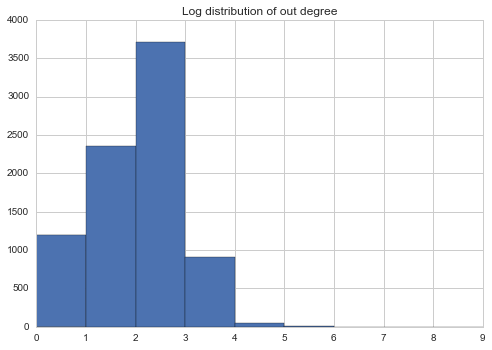

In [53]:
with sns.axes_style('whitegrid'):
    plt.hist([log(len(out) + 1) for out in data.values()], bins=range(10))
    plt.title('Log distribution of out degree')
    plt.show()

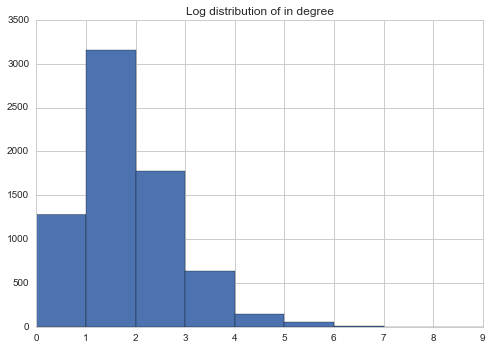

In [54]:
with sns.axes_style('whitegrid'):
    inv = defaultdict(list)
    for rfc, out in data.items():
        for o in out:
            inv[o].append(rfc)
    plt.hist([log(len(v) + 1) for v in inv.values()], bins=range(10))
    plt.title('Log distribution of in degree')
    plt.show()

In [31]:
missing = Counter()
for rfc, out in data.items():
    for other_rfc in out:
        if other_rfc in missing_rfcs:
            missing[other_rfc] += 1
        elif 
missing.most_common()

[(530, 19),
 (418, 3),
 (598, 2),
 (8, 2),
 (9, 2),
 (8222, 1),
 (3350, 1),
 (7000, 1)]

In [42]:
with open('rfc-data.json', 'w') as f:
    json.dump(data, f, sort_keys=True, indent=4)